In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

['Squad2.0',
 'dev-v2.0.json',
 'train-v2.0.json',
 'w266_common',
 '__pycache__',
 'data',
 'model.h5',
 'encoder_model.h5',
 'decoder_model.h5',
 'hhhhhhh.txt',
 'history_tpu_history',
 'tpu_encoder_model.h5',
 'tpu_decoder_model.h5',
 'tpu_model.h5',
 'glove_helper.py',
 'tpu_answer_model_2.h5',
 'tpu_encoder_model_2.h5',
 'tpu_decoder_model_2.h5',
 'tpu_feasibility_model_2.h5',
 'tpu_history_answer_model2',
 'tpu_history_feasibility_model2']

In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper

# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
  """
  Load the data to a pandas dataframe.
  Dataframe Columns:
    title
    para_index
    context
    q_index
    q_id
    q_isimpossible
    q_question
    q_anscount - number of answers
    q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
  """
  result = []
  for pdata in data['data']:
    for para in pdata['paragraphs']:
      for q in para['qas']:
        result.append({
            'title' : pdata['title'],
            'context' : para['context'],
            'q_id' : q['id'],
            'q_isimpossible' : q['is_impossible'],
            'q_question' : q['question'],
            'q_anscount' : len(q['answers']),
            'q_answers' : [a for a in q['answers']],
            'q_answers_text': [a.get("text") for a in q['answers']],
            'context_lowercase': para['context'].lower(),
            'q_question_lowercase' : q['question'].lower(),
            'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']],
            
        })

  return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
  """
  Download a file from google drive with the shared link
  """ 
  data = load_json_file(filename)
  return convert_to_pd(data)

In [2]:
#to make use of CPU and not GPU 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [4]:
!pip install matplotlib

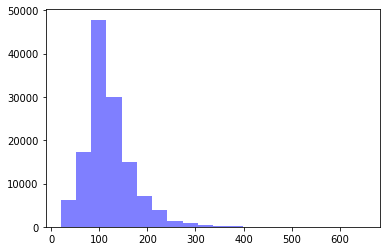

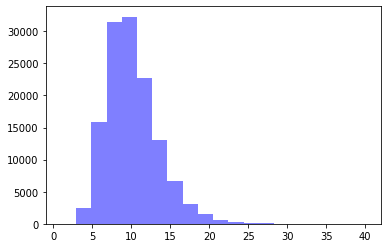

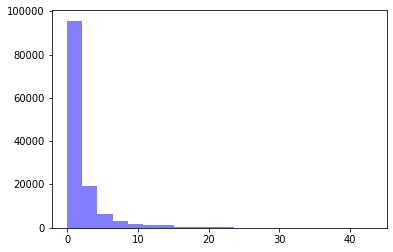

In [5]:
context_lengths = [len(x.split()) for x in train_lists[1]]
question_lengths = [len(x.split()) for x in train_lists[2]]
answer_lengths = [len(x.split()) for x in train_lists[4]]

import matplotlib.pyplot as plt
plt.hist(context_lengths, 20, facecolor='blue', alpha=0.5)
plt.show()
plt.hist(question_lengths, 20, facecolor='blue', alpha=0.5)
plt.show()
plt.hist(answer_lengths, 20, facecolor='blue', alpha=0.5)
plt.show()

In [5]:
context_maxlen = 212
question_maxlen = 16
answer_maxlen = 8

In [6]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
          if i <= num_words:
            vocab[word] = i
        else:
          vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def vectorize_data(tokenizer_obj,train_lists):
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_input_seq = [[vocab['<s>']]+i+[vocab['</s>']] for i in answer_seq]
    answer_target_seq = [i+[vocab['</s>']] for i in answer_seq]
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible_shuffled = answer_impossible[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible_shuffled[:train_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible_shuffled[train_samples:end_samples]
    return (train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible)

train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,\
train_answer_impossible,\
val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,\
val_answer_impossible\
= vectorize_data(tokenizer_obj,train_lists)

print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [7]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
ndim = 100
embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [ ]:
#Function to create the Models
def create_models(embedding_matrix,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  attentionType = 0, # 0 means Luong's 1 means BahdanauUnits
                  BahdanauUnits = 32):
    
    class BahdanauAttention(layers.Layer):
        def __init__(self, units):
            super(BahdanauAttention, self).__init__()
            self.W1 = layers.Dense(units)
            self.W2 = layers.Dense(units)
            self.V =  layers.Dense(1)

        def call(self, inputs):
            query = inputs[0]
            values = inputs[1]
            #print("query shape",query.shape)
            #print("vaues shape",values.shape)
            # query hidden state shape == (batch_size, hidden size)
            # query_with_time_axis shape == (batch_size, 1, hidden size)
            # values shape == (batch_size, max_len, hidden size)
            # we are doing this to broadcast addition along the time axis to calculate the score
            #query_with_time_axis = tf.expand_dims(query, 1)
            #print("query_with_time_axis shape",query_with_time_axis.shape)
            # score shape == (batch_size, max_length, 1)
            # we get 1 at the last axis because we are applying score to self.V
            # the shape of the tensor before applying self.V is (batch_size, max_length, units)
            score = self.V(keras.activations.tanh(
            self.W1(query) + self.W2(values)))

            # attention_weights shape == (batch_size, max_length, 1)
            attention_weights = keras.activations.softmax(score, axis=1)

            # context_vector shape after sum == (batch_size, hidden_size)
            context_vector = attention_weights * values
            #context_vector = tf.reduce_sum(context_vector, axis=1)
            #print("context vector shape",context_vector.shape)

            return context_vector

    def create_memory_using_attention(num_episodes,query,context_outputs,attention_type,BahdanauUnits=32):
        m = layers.Lambda(lambda x: x)(query)
        Dense_Layer_concat_M_q = layers.Dense(units=query.shape[1],activation='tanh')
        if attention_type == 0:
            #use keras attention which is Luong's
            attention_layer = layers.Attention()
        else:
            # use BahdanauAttention
            attention_layer = BahdanauAttention(BahdanauUnits)
        for i in range(num_episodes):
            m_plus_q =layers.concatenate(inputs=[m,query],axis=1)
            if attention_type ==0:
                m_plus_q = Dense_Layer_concat_M_q(m_plus_q)
                m_plus_q = layers.BatchNormalization()(m_plus_q)
            m_plus_q_with_time_axis = tf.keras.backend.expand_dims(m_plus_q, 1)
            context_with_attention = attention_layer([m_plus_q_with_time_axis,context_outputs])
            m = tf.keras.backend.sum(context_with_attention, axis=1)


        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                      recurrent_dropout= dropout_rate,
                                                      return_sequences=True),name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=True),
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=False),
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=False),
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=True),
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_memory_using_attention(num_episodes,question_outputs,context_outputs,attentionType,BahdanauUnits)
    #print(m.shape)
    #print(context_outputs.shape)
    #print(question_outputs.shape)
    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],name='Concatenation_Memory_Question',axis=1)
    #answer_module

    answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
    answer_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Answer_Embedding')(answer_input)
    for i in range(num_layers_gru):
        answer_decoder_layers = layers.GRU(concatenated_tensor.shape[1],dropout=dropout_rate,
                                           recurrent_dropout= dropout_rate,
                                           return_sequences=True,
                                           return_state=True,
                                           name='Answer_GRU_Layer'+str(i)
                                           )
        if i==0:
            answer_outputs,_ = answer_decoder_layers(answer_embeddings,initial_state=concatenated_tensor)
        else:
            answer_outputs,_ = answer_decoder_layers(answer_outputs)
        answer_outputs = layers.BatchNormalization()(answer_outputs)
    answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, activation='softmax')
                                                  ,name='Answer_output')
    answer_decoder_outputs = answer_decoder_dense(answer_outputs)

    answer_model = Model([context_input,question_input,answer_input],answer_decoder_outputs)
    answer_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Question_Embedding").trainable = False
    answer_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Context_Embedding").trainable = False
    answer_model.get_layer("Answer_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Answer_Embedding").trainable = False
    
    #feasibility module
    feasibility_input = Input(shape=(concatenated_tensor.shape[1],), name="FeasibilityInput")
    for i in range(num_dense_layers_feasibility):
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                            activation='relu',name='feasibility_layer_'+str(i))(feasibility_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                            activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)
    feasibility_model = Model(feasibility_input,feasibility_output)

    encoder_model = Model([context_input,question_input], concatenated_tensor)
    decoder_inputs = answer_input
    decoder_state_input_h = Input(shape=(None,), name="DecoderStateInput")


    for i in range(num_layers_gru):
        decoder_layers = answer_model.get_layer('Answer_GRU_Layer'+str(i))
        if i==0:
            decoder_outputs, decoder_state_h = decoder_layers(answer_embeddings,initial_state=decoder_state_input_h)
        else:
            decoder_outputs, decoder_state_h = decoder_layers(decoder_outputs)

    decoder_dense =  answer_model.get_layer('Answer_output')(decoder_outputs)

    decoder_model = Model(
                        [decoder_inputs] + [decoder_state_input_h],
                        [decoder_dense] + [decoder_state_h])
    return (answer_model,encoder_model,decoder_model,feasibility_model)

In [15]:
#Function to get sentences from the predicted answers
def decode_sequence(context_input_seq,
                    question_input_seq,
                    encoder_model,
                    decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict([context_input_seq,question_input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    current_step = 0
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab["<s>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        current_step += 1
        # Sample a token
        #print(output_tokens.shape)
        #print(output_tokens[0,0,0])
        #print(output_tokens[0,0,32984])
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        #print(sampled_token_index)
        if sampled_token_index == 0:
            sampled_char = " "
        else:
            sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '</s>' or len(decoded_sentence) > answer_maxlen:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

In [9]:
#When TPU ENABLED
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
    tpu_answer_model,tpu_encoder_model,tpu_decoder_model,tpu_feasibility_model = create_models(embedding_matrix,
                                                                                      num_unit_gru = 80,
                                                                                      num_layers_gru = 2,
                                                                                      ndim =100,
                                                                                      num_episodes = 2,
                                                                                      num_dense_layer_feasibility_units = 32,
                                                                                      dropout_rate = 0.5,
                                                                                      num_dense_layers_feasibility = 2,
                                                                                      attentionType = 0, # 0 means Luong's 1 means BahdanauUnits
                                                                                      BahdanauUnits = 64)

    tpu_answer_model.compile(optimizer='adam',
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                           )
  
    tpu_feasibility_model.compile(optimizer='adam',
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=[tf.keras.metrics.BinaryAccuracy()]
                           )
  
  


tpu_history_answer_model = tpu_answer_model.fit({'Context_Input':train_context_padded_seq[:20480],
                                                 'Question_Input':train_question_seq_padded[:20480],
                                                 'Answer_Input':train_answer_input_seq_padded[:20480] },
                                                {'Answer_output':train_answer_target_seq_padded[:20480] },
                                                epochs=200,batch_size=32*8,
                                                validation_data=([val_context_padded_seq[:1024],val_question_seq_padded[:1024],train_answer_input_seq_padded[:1024]],
                                                                 val_answer_target_seq_padded[:1024])
                                                )


encoder_prediction = tpu_encoder_model.predict([train_context_padded_seq[:20480],train_question_seq_padded[:20480]])
encoder_validation_prediction = tpu_encoder_model.predict([val_context_padded_seq[:1024],val_question_seq_padded[:1024]])
tpu_history_feasibility_model = tpu_feasibility_model.fit(encoder_prediction,train_answer_impossible[:20480],
                                                          epochs=200,batch_size=32*8,
                                                          validation_data = (encoder_validation_prediction,val_answer_impossible[:1024])
                                                          )


tpu_answer_model.save('tpu_answer_model_2.h5')
tpu_encoder_model.save('tpu_encoder_model_2.h5')
tpu_decoder_model.save('tpu_decoder_model_2.h5')
tpu_feasibility_model.save('tpu_feasibility_model_2.h5')
with open('tpu_history_answer_model2', 'wb') as file_history:
        pickle.dump(tpu_history_answer_model.history, file_history)
with open('tpu_history_feasibility_model2', 'wb') as file_history:
        pickle.dump(tpu_history_feasibility_model.history, file_history)

INFO:tensorflow:Initializing the TPU system: 10.89.189.58:8470


INFO:tensorflow:Initializing the TPU system: 10.89.189.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Context output shape (None, None, 160)
Train on 20480 samples, validate on 1024 samples
Epoch 1/200
20480/20480 [==============================] - 109s 5ms/sample - loss: 0.6281 - sparse_categorical_accuracy: 0.2449 - val_loss: 0.4041 - val_sparse_categorical_accuracy: 0.5046
Epoch 2/200
20480/20480 [==============================] - 52s 3ms/sample - loss: 0.4928 - sparse_categorical_accuracy: 0.3226 - val_loss: 0.3942 - val_sparse_categorical_accuracy: 0.5430
Epoch 3/200
20480/20480 [==============================] - 52s 3ms/sample - loss: 0.4815 - sparse_categorical_accuracy: 0.3515 - val_loss: 0.3973 - val_sparse_categorical_accuracy: 0.3919
Epoch 4/200
20480/20480 [==============================] - 52s 3ms/sample - loss: 0.4625 - sparse_categorical_accuracy: 0.4360 - val_loss: 0.4274 - val_sparse_categorical_accuracy: 0.3436
Epoch 5/200
20480/20480 [==============================] - 52s 3ms/sample - loss: 0.4532 - sparse_categorical_accuracy: 0.4486 - val_loss: 0.4519 - val_sparse_

In [ ]:
#When GPU ENABLED
gpu_answer_model,gpu_encoder_model,gpu_decoder_model,gpu_feasibility_model = create_models(embedding_matrix,
                                                                                      num_unit_gru = 16,
                                                                                      num_layers_gru = 2,
                                                                                      ndim =100,
                                                                                      num_episodes = 2,
                                                                                      num_dense_layer_feasibility_units = 16,
                                                                                      dropout_rate = 0.5,
                                                                                      num_dense_layers_feasibility = 2,
                                                                                      attentionType = 0, # 0 means Luong's 1 means BahdanauUnits
                                                                                      BahdanauUnits = 64)

adam_optim = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
gpu_answer_model.compile(optimizer=adam_optim,
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                           )

gpu_answer_model.summary()
gpu_feasibility_model.compile(optimizer=adam_optim,
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=[tf.keras.metrics.BinaryAccuracy()]
                           )
gpu_feasibility_model.summary()
gpu_history_answer_model = gpu_answer_model.fit({'Context_Input':train_context_padded_seq[:100],
                                                 'Question_Input':train_question_seq_padded[:100],
                                                 'Answer_Input':train_answer_input_seq_padded[:100] },
                                                {'Answer_output':train_answer_target_seq_padded[:100] },
                                                epochs=200,batch_size=10,
                                                validation_data=([val_context_padded_seq[:20],val_question_seq_padded[:20],train_answer_input_seq_padded[:20]],
                                                                 val_answer_target_seq_padded[:20]))

In [17]:
encoder_prediction = gpu_encoder_model.predict([train_context_padded_seq[:100],train_question_seq_padded[:100]])
encoder_validation_prediction = gpu_encoder_model.predict([val_context_padded_seq[:20],val_question_seq_padded[:20]])
gpu_history_feasibility_model = gpu_feasibility_model.fit(encoder_prediction,train_answer_impossible[:100],
                                                          epochs=200,batch_size=10,
                                                          validation_data = (encoder_validation_prediction,val_answer_impossible[:20])
                                                          )


gpu_answer_model.save('gpu_answer_model_2.h5')
gpu_encoder_model.save('gpu_encoder_model_2.h5')
gpu_decoder_model.save('gpu_decoder_model_2.h5')
gpu_feasibility_model.save('gpu_feasibility_model_2.h5')
with open('gpu_history_answer_model2', 'wb') as file_history:
        pickle.dump(gpu_history_answer_model.history, file_history)
with open('gpu_history_feasibility_model2', 'wb') as file_history:
        pickle.dump(gpu_history_feasibility_model.history, file_history)

Train on 100 samples, validate on 20 samples
Epoch 1/200
100/100 [==============================] - 1s 9ms/sample - loss: 0.9869 - binary_accuracy: 0.4700 - val_loss: 3.8154 - val_binary_accuracy: 0.5500
Epoch 2/200
100/100 [==============================] - 0s 314us/sample - loss: 0.8409 - binary_accuracy: 0.5500 - val_loss: 6.9284 - val_binary_accuracy: 0.5500
Epoch 3/200
100/100 [==============================] - 0s 397us/sample - loss: 0.6492 - binary_accuracy: 0.6600 - val_loss: 2.5105 - val_binary_accuracy: 0.5500
Epoch 4/200
100/100 [==============================] - 0s 399us/sample - loss: 0.6546 - binary_accuracy: 0.6600 - val_loss: 1.2679 - val_binary_accuracy: 0.5500
Epoch 5/200
100/100 [==============================] - 0s 476us/sample - loss: 0.6130 - binary_accuracy: 0.6700 - val_loss: 1.4152 - val_binary_accuracy: 0.5500
Epoch 6/200
100/100 [==============================] - 0s 416us/sample - loss: 0.5686 - binary_accuracy: 0.7400 - val_loss: 1.3996 - val_binary_accuracy

100/100 [==============================] - 0s 364us/sample - loss: 0.2866 - binary_accuracy: 0.8800 - val_loss: 2.2827 - val_binary_accuracy: 0.6000
Epoch 102/200
100/100 [==============================] - 0s 343us/sample - loss: 0.2329 - binary_accuracy: 0.9000 - val_loss: 2.2981 - val_binary_accuracy: 0.5000
Epoch 103/200
100/100 [==============================] - 0s 325us/sample - loss: 0.3741 - binary_accuracy: 0.8200 - val_loss: 2.1747 - val_binary_accuracy: 0.4500
Epoch 104/200
100/100 [==============================] - 0s 336us/sample - loss: 0.3603 - binary_accuracy: 0.8700 - val_loss: 2.0072 - val_binary_accuracy: 0.5500
Epoch 105/200
100/100 [==============================] - 0s 382us/sample - loss: 0.4157 - binary_accuracy: 0.8100 - val_loss: 1.7725 - val_binary_accuracy: 0.4000
Epoch 106/200
100/100 [==============================] - 0s 367us/sample - loss: 0.3455 - binary_accuracy: 0.8300 - val_loss: 1.6990 - val_binary_accuracy: 0.4500
Epoch 107/200
100/100 [=============

In [25]:
import pickle
favorite_color = pickle.load( open( "gpu_history_answer_model2", "rb" ) )

In [26]:
favorite_color

{'loss': [1.0021465957164764,
  0.8581745982170105,
  0.622495511174202,
  0.454390549659729,
  0.3440942779183388,
  0.3245418131351471,
  0.29935378283262254,
  0.29812543243169787,
  0.2746981203556061,
  0.28004816025495527,
  0.2624157935380936,
  0.26698136031627656,
  0.25928100645542146,
  0.25722589492797854,
  0.25440490916371344,
  0.25769960433244704,
  0.24973910450935363,
  0.2420899584889412,
  0.23934334218502046,
  0.23876624479889869,
  0.234937684237957,
  0.2327175408601761,
  0.22930850982666015,
  0.22928718999028205,
  0.22982289344072343,
  0.225761841237545,
  0.22956837564706803,
  0.22473053336143495,
  0.21714958176016808,
  0.2204847015440464,
  0.21618397086858748,
  0.21761858314275742,
  0.21991693899035453,
  0.21742043346166612,
  0.21079502627253532,
  0.21146002858877183,
  0.20340538248419762,
  0.21868807077407837,
  0.21210432946681976,
  0.20876455157995225,
  0.20554210022091865,
  0.20476813465356827,
  0.20861533284187317,
  0.2063750237226486

In [10]:
inference_answer_model,inference_encoder,inference_decoder,inference_feasibility_model = create_models(embedding_matrix,
                                                                                      num_unit_gru = 80,
                                                                                      num_layers_gru = 2,
                                                                                      ndim =100,
                                                                                      num_episodes = 2,
                                                                                      num_dense_layer_feasibility_units = 32,
                                                                                      dropout_rate = 0.5,
                                                                                      num_dense_layers_feasibility = 2,
                                                                                      attentionType = 0, # 0 means Luong's 1 means BahdanauUnits
                                                                                      BahdanauUnits = 64)

inference_encoder.load_weights('tpu_encoder_model_2.h5')
inference_decoder.load_weights('tpu_decoder_model_2.h5')

Context output shape (None, None, 160)


In [19]:

for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(context_input_seq,question_input_seq,gpu_encoder_model,gpu_decoder_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Decoded sentence:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: in 2003 what well known u s secretary of state declared the situation in darfur as an act of genocide
Decoded sentence: </s> 
Actual answer: <s> colin powell </s>
question: what shape was the sixaxis final model in
Decoded sentence: </s> 
Actual answer: <s> </s>
question: what is a team called that is in the process of joining a league
Decoded sentence: </s> 
Actual answer: <s> a probational franchise </s>
question: what is lord justice sedley s nationality
Decoded sentence: </s> 
Actual answer: <s> </s>
question: what do field windings provide
Decoded sentence: </s> 
Actual answer: <s> flux </s>
question: what period ranged from the 41st to the 29th century bc
Decoded sentence: </s> 
Actual answer: <s> </s>
question: what would be needed to support metadata and obviate the need for tags
Decoded sentence: </s> 
Actual answer: <s> a standard container format </s>
question: how much energy could a capacitor in a disposable camera release
Decoded sentence: </s> 
Actual answer: <

In [18]:
' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[0].tolist() if i !=0])

'<s> mesrop mashtots </s>'

In [11]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index+3000: seq_index +3000+ 1]
    question_input_seq = train_question_seq_padded[seq_index+3000: seq_index+3000 + 1]
    decoded_sentence = decode_sequence(context_input_seq,question_input_seq,inference_encoder,inference_decoder)
    print('-')
    print('Decoded sentence:', decoded_sentence)

-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: </s> 


In [27]:
#Define Experiments using random choice
import random
num_unit_gru_list = [32,64,80,100]
num_layers_gru_list = [1,2]
num_episodes_list = [1,2,3]
num_dense_layer_feasibility_units_list = [16,32]
dropout_rate_list = [0.4,0.5,0.6,0.7]
num_dense_layers_feasibility_list = [1,2]
attentionType_list = [0,1]
BahdanauUnits_list = [32,64]
learning_rate_list = [.005,.001]
Experiments = {}
for i in range(6):
    experiment_name = 'Experiment'+str(i)
    experiment_hyperparam_dic = {}
    experiment_num_unit_gru = random.choice(num_unit_gru_list)
    experiment_num_layers_gru = random.choice(num_layers_gru_list)
    experiment_num_episodes = random.choice(num_episodes_list)
    experiment_num_dense_layer_feasibility_units = random.choice(num_dense_layer_feasibility_units_list)
    experiment_dropout_rate = random.choice(dropout_rate_list)
    experiment_num_dense_layers_feasibility = random.choice(num_dense_layers_feasibility_list)
    experiment_attentionType = random.choice(attentionType_list)
    experiment_BahdanauUnits = random.choice(BahdanauUnits_list)
    experiment_learning_rate = random.choice(learning_rate_list)
    experiment_hyperparam_dic['num_unit_gru'] = experiment_num_unit_gru
    experiment_hyperparam_dic['num_layers_gru'] = experiment_num_layers_gru
    experiment_hyperparam_dic['num_episodes'] = experiment_num_episodes
    experiment_hyperparam_dic['num_dense_layer_feasibility_units'] = experiment_num_dense_layer_feasibility_units
    experiment_hyperparam_dic['dropout_rate'] = experiment_dropout_rate
    experiment_hyperparam_dic['num_dense_layers_feasibility'] = experiment_num_dense_layers_feasibility
    experiment_hyperparam_dic['attentionType'] = experiment_attentionType
    experiment_hyperparam_dic['BahdanauUnits'] = experiment_BahdanauUnits
    experiment_hyperparam_dic['learning_rate'] = experiment_learning_rate
    Experiments[experiment_name] = experiment_hyperparam_dic
    
print(Experiments)

{'Experiment0': {'num_unit_gru': 64, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 16, 'dropout_rate': 0.4, 'num_dense_layers_feasibility': 1, 'attentionType': 0, 'BahdanauUnits': 32, 'learning_rate': 0.005}, 'Experiment1': {'num_unit_gru': 80, 'num_layers_gru': 1, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 32, 'dropout_rate': 0.6, 'num_dense_layers_feasibility': 2, 'attentionType': 0, 'BahdanauUnits': 32, 'learning_rate': 0.001}, 'Experiment2': {'num_unit_gru': 32, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 16, 'dropout_rate': 0.5, 'num_dense_layers_feasibility': 1, 'attentionType': 0, 'BahdanauUnits': 64, 'learning_rate': 0.005}, 'Experiment3': {'num_unit_gru': 100, 'num_layers_gru': 2, 'num_episodes': 1, 'num_dense_layer_feasibility_units': 16, 'dropout_rate': 0.4, 'num_dense_layers_feasibility': 1, 'attentionType': 1, 'BahdanauUnits': 32, 'learning_rate': 0.001}, 'Experiment4': {'num_unit_gru': 32, 'num_l

In [28]:
Experiments_Dic = {'Experiment0': {'num_unit_gru': 80,
  'num_layers_gru': 1,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'attentionType': 0,
  'BahdanauUnits': 64,
  'learning_rate': 0.001},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 1,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 16,
  'dropout_rate': 0.4,
  'num_dense_layers_feasibility': 1,
  'attentionType': 0,
  'BahdanauUnits': 64,
  'learning_rate': 0.005},
 'Experiment2': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 16,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 1,
  'attentionType': 1,
  'BahdanauUnits': 64,
  'learning_rate': 0.005},
 'Experiment3': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'attentionType': 1,
  'BahdanauUnits': 64,
  'learning_rate': 0.005},
 'Experiment4': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'attentionType': 0,
  'BahdanauUnits': 64,
  'learning_rate': 0.001},
 'Experiment5': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.4,
  'num_dense_layers_feasibility': 2,
  'attentionType': 1,
  'BahdanauUnits': 32,
  'learning_rate': 0.005}}

In [25]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class input_model(tf.keras.Model):
    def __init__(self,embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,dropout_rate):
        super(input_model, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        #self.context_input_layer = Input(shape=(None,),dtype='int32',name='Context_Input')
        self.context_embeddings_layer = layers.Embedding(vocab_size+1,
                                                         ndim,
                                                         mask_zero=True,
                                                         weights =[embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        #self.context_embeddings_layer.set_weights([embedding_matrix])
        #self.context_embeddings_layer.trainable = False 
        self.context_output_layers = []
        self.batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(layers.GRU(self.num_unit_gru,
                                                                               dropout=self.dropout_rate,
                                                                               recurrent_dropout= dropout_rate,
                                                                               recurrent_initializer='glorot_uniform',
                                                                               return_sequences=True),
                                                                   merge_mode='sum',
                                                                   name='Context_Bid_Layer'+str(i))
                                         )
            self.batch_normalization_layers.append(layers.BatchNormalization())

    def call(self,context_input):
        #context_input = self.context_input_layer(context_input)
        context_embeddings = self.context_embeddings_layer(context_input)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.batch_normalization_layers[i](context_outputs)  
        return context_outputs

class question_model(tf.keras.Model):
    def __init__(self,embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,dropout_rate):
        super(question_model, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        #self.question_input_layer = Input(shape=(None,),dtype='int32',name='Context_Input')
        self.question_embeddings_layer = layers.Embedding(vocab_size+1,
                                                          ndim,
                                                          mask_zero=True,
                                                          weights =[embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
        #self.question_embeddings_layer.set_weights([embedding_matrix])
        #self.question_embeddings_layer.trainable = False   
        self.question_output_layers = []
        self.batch_normalization_layers = []
        for i in range(num_layers_gru):

            if i==0 and num_layers_gru >1:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=True),
                                                             merge_mode='sum',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            elif i==0 and num_layers_gru ==1:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=False),
                                                             merge_mode='sum',
                                                             name='Question_Bid_Layer'+str(i))
                                             )
            elif i==(num_layers_gru-1):
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=False),
                                                              merge_mode='sum',
                                                              name='Question_Bid_Layer'+str(i))
                                             )
            else:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=True),
                                                                        merge_mode='sum',
                                                                        name='Question_Bid_Layer'+str(i))
                                              )
            self.batch_normalization_layers.append(layers.BatchNormalization())

    def call(self,question_input):
        #question_input = self.question_input_layer(question_input)
        question_embeddings = self.question_embeddings_layer(question_input)
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.batch_normalization_layers[i](question_outputs)  
        return question_outputs


class feasibility_model(tf.keras.Model):
    def __init__(self, num_unit_gru,num_dense_layers_feasibility,dropout_rate,
                 BahdanauUnits,num_dense_layer_feasibility_units):
        super(feasibility_model, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.attention_layer = BahdanauAttention_model2(BahdanauUnits)
        #self.feasibility_input_layer = Input(shape=(num_unit_gru,),dtype='int32',name='FeasibilityInput')
        self.dense_layers = []
        self.batch_normalization_layers = []
        self.dropout_layers = []
        for i in range(num_dense_layers_feasibility):
            self.dense_layers.append(layers.Dense(num_dense_layer_feasibility_units,
                                                  activation='relu',name='feasibility_layer_'+str(i))
                                    )
            self.batch_normalization_layers.append(layers.BatchNormalization())
            self.dropout_layers.append(layers.Dropout(self.dropout_rate))
        
        self.feasibility_output_layer = layers.Dense(1,activation='sigmoid',name='feasibility_output')

    
    def call(self,question,context):
        attention_output,attention_weights = self.attention_layer(question,context)
        #feasibility_input = self.feasibility_input_layer(attention_output)
        for i in range(len(self.dense_layers)):
            if i == 0:
                dense = self.dense_layers[i](attention_output)
            else:
                dense = self.dense_layers[i](dense)
            dense = self.batch_normalization_layers[i](dense)
            dense = self.dropout_layers[i](dense)
        feasibility_output = self.feasibility_output_layer(dense)
        
        return feasibility_output


class answer_model(tf.keras.Model):
    def __init__(self,embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,dropout_rate,BahdanauUnits):
        super(answer_model, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.attention_layer = BahdanauAttention_model2(BahdanauUnits)
        #self.answer_input_layer = Input(shape=(None,),dtype='int32',name='Answer_Input')
        self.answer_embedding_layer = layers.Embedding(vocab_size+1,
                                                       ndim,
                                                       mask_zero=True,
                                                       weights =[embedding_matrix],
                                                       trainable = False,
                                                       name='Answer_Embedding')
        #self.answer_embedding_layer.set_weights([embedding_matrix])
        #self.answer_embedding_layer.trainable = False
        self.answer_output_layers = []
        self.batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.answer_output_layers.append(layers.GRU(self.num_unit_gru,
                                                        dropout=self.dropout_rate,
                                                        recurrent_dropout= self.dropout_rate,
                                                        return_sequences=True,
                                                        return_state=True,
                                                        recurrent_initializer='glorot_uniform',
                                                        name='Answer_GRU_Layer'+str(i)
                                                       )
                                              )
            self.batch_normalization_layers.append(layers.BatchNormalization())
        
        
        self.answer_decoder_dense = layers.Dense(vocab_size+1,name='Answer_output')
        
    
    def call(self,target_input,answer_hidden,question,context):
        attention_output,attention_weights = self.attention_layer(answer_hidden,context)
        #answer_input = self.answer_input_layer(target_input)
        answer_embeddings = self.answer_embedding_layer(target_input)
        answer_concat = tf.concat([tf.expand_dims(attention_output, 1),
                                   tf.expand_dims(question, 1),
                                   answer_embeddings], axis=-1)
        for i in range(len(self.answer_output_layers)):
            answer_outputs,hidden_state = self.answer_output_layers[i](answer_concat)
            answer_outputs   = self.batch_normalization_layers[i](answer_outputs)
        answer_outputs = tf.reshape(answer_outputs, (-1, answer_outputs.shape[2]))

        answer_decoder_outputs = self.answer_decoder_dense(answer_outputs)
        return answer_decoder_outputs,hidden_state,attention_weights
    

In [26]:
def create_models2(embedding_matrix,
                   vocab_size,
                   num_unit_gru = 64,
                   num_layers_gru = 2,
                   ndim =100,
                   num_episodes = 2,
                   num_dense_layer_feasibility_units = 16,
                   dropout_rate = 0.5,
                   num_dense_layers_feasibility = 1,
                   BahdanauUnits = 32):
    input_module_model = input_model(embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,dropout_rate)
    question_module_model = question_model(embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,
                                           dropout_rate)
    feasibility_module_model = feasibility_model(num_unit_gru,num_dense_layers_feasibility,dropout_rate,
                                                 BahdanauUnits,num_dense_layer_feasibility_units)
    answer_module_model = answer_model(embedding_matrix,vocab_size,ndim,num_unit_gru,num_layers_gru,
                                       dropout_rate,BahdanauUnits)
    #question_module_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #question_module_model.get_layer("Question_Embedding").trainable = False
    #input_module_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #input_module_model.get_layer("Context_Embedding").trainable = False
    #answer_module_model.get_layer("Answer_Embedding").set_weights([embedding_matrix])
    #answer_module_model.get_layer("Answer_Embedding").trainable = False
    return (input_module_model,question_module_model,feasibility_module_model,answer_module_model)

In [27]:
answer_optimizer = tf.keras.optimizers.Adam()
answer_loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def answer_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = answer_loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


@tf.function
def answer_train_step(inp,ques,targ,input_module_model,question_module_model,answer_module_model):
    loss = 0

    with tf.GradientTape() as tape:
        context_output = input_module_model(inp)
        question_output = question_module_model(ques)
        answer_hidden = question_output

        dec_input = tf.expand_dims(targ[:,0], 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, answer_hidden, _ = answer_module_model(dec_input,
                                                                answer_hidden,
                                                                question_output,
                                                                context_output)
            
            
            loss += answer_loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = input_module_model.trainable_variables\
                    + question_module_model.trainable_variables\
                    + answer_module_model.trainable_variables

        gradients = tape.gradient(loss, variables)

        answer_optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [28]:
TRAIN_BUFFER_SIZE = train_context_padded_seq[:1024].shape[0]
BATCH_SIZE = 10
steps_per_epoch = TRAIN_BUFFER_SIZE//BATCH_SIZE
train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:1024],
                                                    train_question_seq_padded[:1024],
                                                    train_answer_seq_padded[:1024],
                                                    train_answer_input_seq_padded[:1024],
                                                    train_answer_target_seq_padded[:1024],
                                                    train_answer_impossible[:1024])).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:1024],
                                                  val_question_seq_padded[:1024],
                                                  val_answer_seq_padded[:1024],
                                                  val_answer_input_seq_padded[:1024],
                                                  val_answer_target_seq_padded[:1024],
                                                  val_answer_impossible[:1024]))
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [29]:
input_module_model,\
question_module_model,\
feasibility_module_model,\
answer_module_model = create_models2(embedding_matrix,
                                     vocab_size,
                                     num_unit_gru = 64,
                                     num_layers_gru = 2,
                                     ndim =100,
                                     num_episodes = 2,
                                     num_dense_layer_feasibility_units = 16,
                                     dropout_rate = 0.5,
                                     num_dense_layers_feasibility = 1,
                                     BahdanauUnits = 32)

In [35]:
import time
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    total_loss = 0

    for (batch, (batch_train_context_padded_seq,
                 batch_train_question_seq_padded,
                 batch_train_answer_seq_padded,
                 batch_train_answer_input_seq_padded,
                 batch_train_answer_target_seq_padded,
                 batch_train_answer_impossible)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = answer_train_step(batch_train_context_padded_seq,
                                       batch_train_question_seq_padded,
                                       batch_train_answer_input_seq_padded,
                                       input_module_model,
                                       question_module_model,
                                       answer_module_model)
        total_loss += batch_loss

        #if batch % 50 == 0:
        #    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
        #                                           batch,
        #                                           batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    #if (epoch + 1) % 2 == 0:
    #    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Loss 1.3073
Time taken for 1 epoch 81.7281723022461 sec

Epoch 2 Loss 1.2994
Time taken for 1 epoch 86.71994471549988 sec

Epoch 3 Loss 1.2703
Time taken for 1 epoch 86.68625092506409 sec

Epoch 4 Loss 1.2503
Time taken for 1 epoch 86.77677011489868 sec

Epoch 5 Loss 1.2250
Time taken for 1 epoch 93.09805846214294 sec

Epoch 6 Loss 1.1992
Time taken for 1 epoch 87.32548427581787 sec

Epoch 7 Loss 1.1634
Time taken for 1 epoch 87.51275777816772 sec

Epoch 8 Loss 1.1466
Time taken for 1 epoch 87.00956726074219 sec

Epoch 9 Loss 1.1239
Time taken for 1 epoch 86.98462700843811 sec

Epoch 10 Loss 1.0974
Time taken for 1 epoch 87.04913902282715 sec

Epoch 11 Loss 1.0717
Time taken for 1 epoch 86.8537986278534 sec

Epoch 12 Loss 1.0428
Time taken for 1 epoch 87.4265365600586 sec

Epoch 13 Loss 1.0145
Time taken for 1 epoch 93.05396008491516 sec

Epoch 14 Loss 0.9806
Time taken for 1 epoch 87.18935823440552 sec

Epoch 15 Loss 0.9498
Time taken for 1 epoch 89.19645571708679 sec

Epoch 1

In [36]:
def decode_sentence2(context_input_seq,
                     question_input_seq,
                     input_model,
                     question_model,
                     answer_model):
    decoded_sentence = ''
    context_output = input_module_model(context_input_seq)
    question_output = question_module_model(question_input_seq)
    answer_hidden = question_output
    dec_input = tf.expand_dims([vocab["<s>"]], 0)

    for t in range(answer_maxlen):
        predictions, answer_hidden, _ = answer_module_model(dec_input,
                                                            answer_hidden,
                                                            question_output,
                                                            context_output)
        sampled_token_index = tf.argmax(predictions[0]).numpy()
        
        if sampled_token_index == 0:
            sampled_char = " "
        else:
            sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "
        if id_vocab[sampled_token_index] == '</s>':
            return decoded_sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([sampled_token_index], 0)

    return decoded_sentence

In [39]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence2(context_input_seq,
                                       question_input_seq,
                                       input_module_model,
                                       question_module_model,
                                       answer_module_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Decoded sentence:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what does ban bossy encourage
Decoded sentence: leadership in girls </s> 
Actual answer: <s> leadership in girls </s>
question: what area had high windows just below ground level
Decoded sentence: </s> 
Actual answer: <s> </s>
question: what happens if a plant looses roots or its shoots
Decoded sentence: can often regrow it </s> 
Actual answer: <s> can often regrow it </s>
question: what was typically worn after the loss of a loved one in the roman republic
Decoded sentence: the toga pulla </s> 
Actual answer: <s> the toga pulla </s>
question: what instruments are used in armenian folk music
Decoded sentence: the duduk the kanun </s> 
Actual answer: <s> the duduk the dhol the zurna and the kanun </s>
question: why does a litigant initiate a lawsuit under the civil rights act of 1801
Decoded sentence: </s> 
Actual answer: <s> </s>
question: at what rate have glaciers travelled during surges
Decoded sentence: 90 m 300 ft per day </s> 
Actual answer: <s> 90 m 300 ft per day </s>

In [8]:
#Function to create the Models with attention using keras layers
def create_models3(embedding_matrix,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_dense_layer_feasibility_units = 32,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 2,
                  answer_maxlen = 8):
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_state=True,
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs,context_h_state_fwd,context_h_state_bkwd = context_outputs_layers(context_embeddings)
        else:
            context_outputs,context_h_state_fwd,context_h_state_bkwd = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
        context_h_state = layers.average([context_h_state_fwd,context_h_state_bkwd])
    #print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    
    #Context with attention from Question
    #q_with_time_axis = tf.keras.backend.expand_dims(question_outputs, 1)
    #context_with_attention = layers.Attention(name='question_context_attention')([q_with_time_axis,context_outputs])
    #context_with_question = tf.keras.backend.sum(context_with_attention, axis=1)
    #print(m.shape)
    #print(context_outputs.shape)
    #print(question_outputs.shape)
    #concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
    #                                         name='Concatenation_Memory_Question',axis=1)
    #answer_module

    answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
    answer_embeddings = layers.Embedding(vocab_size+1,
                                         ndim,mask_zero=True,
                                         name='Answer_Embedding')(answer_input)
    answer_embedding_plus_question = layers.concatenate(
                                       inputs = [tf.tile(tf.keras.backend.expand_dims(question_outputs, 1),
                                                         tf.constant([1,answer_maxlen+2,1],
                                                                    tf.int32)),
                                                 answer_embeddings],axis=-1)
    for i in range(num_layers_gru):
        answer_decoder_layers = layers.GRU(num_unit_gru,
                                           dropout=dropout_rate,
                                           recurrent_dropout= dropout_rate,
                                           recurrent_initializer='glorot_uniform',
                                           return_sequences=True,
                                           return_state=True,
                                           name='Answer_GRU_Layer'+str(i)
                                           )
        if i==0:
            answer_outputs,_ = answer_decoder_layers(answer_embedding_plus_question,
                                                     initial_state=context_h_state)
        else:
            answer_outputs,_ = answer_decoder_layers(answer_outputs)
        answer_outputs = layers.BatchNormalization()(answer_outputs)
        
    answer_with_attention = layers.Attention(name='answer_context_attention')([answer_outputs,context_outputs])
    answer_attention_plus_hidden = layers.Concatenate(axis=-1,name='answer_attention_plus_hidden')\
                                   ([answer_with_attention,answer_outputs])
    
    #answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, 
    #                                                           activation='softmax')
    #                                              ,name='Answer_output')
    answer_decoder_dense0 = layers.Dense(num_unit_gru,
                                         activation='tanh',name = 'Answer_decoder_dense0')
    answer_decoder_dense0_output = answer_decoder_dense0(answer_attention_plus_hidden) 
    answer_decoder_dense = layers.Dense(vocab_size+1, 
                                        activation='softmax',
                                        name='Answer_output')
    answer_decoder_outputs = answer_decoder_dense(answer_decoder_dense0_output)

    answer_model = Model([context_input,question_input,answer_input],answer_decoder_outputs)
    answer_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Question_Embedding").trainable = False
    answer_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Context_Embedding").trainable = False
    answer_model.get_layer("Answer_Embedding").set_weights([embedding_matrix])
    answer_model.get_layer("Answer_Embedding").trainable = False
    
    #feasibility module
    feasibility_input = Input(shape=(context_h_state.shape[1],), name="FeasibilityContextStateInput")
    feasibility_q_input = Input(shape=(question_outputs.shape[1],),name="FeasibilityQuestionOutput")
    feasibility_concat = layers.concatenate(inputs = [feasibility_input,feasibility_q_input])
    for i in range(num_dense_layers_feasibility):
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                            activation='relu',name='feasibility_layer_'+str(i))(feasibility_concat)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                            activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)
    feasibility_model = Model([feasibility_input,feasibility_q_input],feasibility_output)

    encoder_model = Model([context_input,question_input], [context_h_state,
                                                           context_outputs,
                                                           question_outputs])
    decoder_inputs = answer_input
    decoder_state_input_h = Input(shape=(None,), name="DecoderStateInput")
    decoder_context_input = Input(shape=(None,None,),name="DecoderContextInput")
    decoder_question_input = Input(shape=(None,),name="DecoderQuestionInput")
    decoder_answer_embeddings = answer_model.get_layer('Answer_Embedding')(decoder_inputs)
    decoder_answer_embedding_plus_question = layers.concatenate(
                                                 inputs = [tf.keras.backend.expand_dims(decoder_question_input, 1),
                                                 decoder_answer_embeddings],axis=-1)
    
    for i in range(num_layers_gru):
        decoder_layers = answer_model.get_layer('Answer_GRU_Layer'+str(i))
        if i==0:
            decoder_outputs, decoder_state_h = decoder_layers(decoder_answer_embedding_plus_question,
                                                              initial_state=decoder_state_input_h)
        else:
            decoder_outputs, decoder_state_h = decoder_layers(decoder_outputs)
    decoder_answer_attention = answer_model.get_layer('answer_context_attention')([decoder_outputs,
                                                                                   decoder_context_input])
    decoder_answer_attention_plus_hidden = answer_model.get_layer('answer_attention_plus_hidden')\
                                           ([decoder_answer_attention,decoder_outputs])
    decoder_dense0 = answer_model.get_layer('Answer_decoder_dense0')(decoder_answer_attention_plus_hidden)
    decoder_dense =  answer_model.get_layer('Answer_output')(decoder_dense0)

    decoder_model = Model(
                        [decoder_inputs] + [decoder_state_input_h]+
                        [decoder_context_input]+[decoder_question_input],
                        [decoder_dense] + [decoder_state_h])
    return (answer_model,encoder_model,decoder_model,feasibility_model)

In [9]:
#Function to get sentences from the predicted answers
def decode_sequence3(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     decoder_model):
    # Encode the input as state vectors.
    states_value,contexts,question = encoder_model.predict([context_input_seq,question_input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    current_step = 0
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab["<s>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value] + [contexts]+[question])
        current_step += 1
        # Sample a token
        #print(output_tokens.shape)
        #print(output_tokens[0,0,0])
        #print(output_tokens[0,0,32984])
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        #print(sampled_token_index)
        if sampled_token_index == 0:
            sampled_char = " "
        else:
            sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '</s>' or len(decoded_sentence) > answer_maxlen:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

In [10]:
tf.config.optimizer.set_experimental_options({'arithmetic_optimization':False,
                                              'dependency_optimization':False,
                                              'pin_to_host_optimization':False,
                                              'min_graph_nodes':-1,
                                            'disable_meta_optimizer':True})
#When GPU ENABLED
gpu_answer_model,\
gpu_encoder_model,\
gpu_decoder_model,\
gpu_feasibility_model = create_models3(embedding_matrix,
                                      num_unit_gru = 64,
                                      num_layers_gru = 2,
                                      ndim =100,
                                      num_dense_layer_feasibility_units = 32,
                                      dropout_rate = 0.5,
                                      num_dense_layers_feasibility = 2,
                                      answer_maxlen = answer_maxlen )

adam_optim = keras.optimizers.Adam(learning_rate=0.001)
gpu_answer_model.compile(optimizer=adam_optim,
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                           )

gpu_answer_model.summary()
gpu_feasibility_model.compile(optimizer=adam_optim,
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=[tf.keras.metrics.BinaryAccuracy()]
                           )
gpu_feasibility_model.summary()
gpu_history_answer_model = gpu_answer_model.fit({'Context_Input':train_context_padded_seq[:1024],
                                                 'Question_Input':train_question_seq_padded[:1024],
                                                 'Answer_Input':train_answer_input_seq_padded[:1024] },
                                                {'Answer_output':train_answer_target_seq_padded[:1024] },
                                                epochs=50,batch_size=10,
                                                validation_data=([val_context_padded_seq[:20],
                                                                  val_question_seq_padded[:20],
                                                                 train_answer_input_seq_padded[:20]],
                                                                 val_answer_target_seq_padded[:20]))

encoder_prediction,encoder_question_prediction,_ = gpu_encoder_model.predict([train_context_padded_seq[:1024],
                                                                              train_question_seq_padded[:1024]])
encoder_validation_prediction,encoder_validation_question_prediction,_ = gpu_encoder_model.predict(
                                                                          [val_context_padded_seq[:20],
                                                                          val_question_seq_padded[:20]])
gpu_history_feasibility_model = gpu_feasibility_model.fit([encoder_prediction,encoder_question_prediction],
                                                          train_answer_impossible[:1024],
                                                          epochs=50,batch_size=10,
                                                          validation_data = ([encoder_validation_prediction,
                                                                             encoder_validation_question_prediction],
                                                                             val_answer_impossible[:20])
                                                          )


gpu_answer_model.save('gpu_answer_model_2.h5')
gpu_encoder_model.save('gpu_encoder_model_2.h5')
gpu_decoder_model.save('gpu_decoder_model_2.h5')
gpu_feasibility_model.save('gpu_feasibility_model_2.h5')
with open('gpu_history_answer_model2', 'wb') as file_history:
        pickle.dump(gpu_history_answer_model.history, file_history)
with open('gpu_history_feasibility_model2', 'wb') as file_history:
        pickle.dump(gpu_history_feasibility_model.history, file_history)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Question_Input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
Question_Embedding (Embedding)  (None, None, 100)    8870200     Question_Input[0][0]             
__________________________________________________________________________________________________
Question_Bid_Layer0 (Bidirectio (None, None, 64)     63744       Question_Embedding[0][0]         
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, 64)     256         Question_Bid_Layer0[0][0]        
______________________________________________________________________________________________

1024/1024 [==============================] - 148s 144ms/sample - loss: 4.0931 - sparse_categorical_accuracy: 0.1656 - val_loss: 2.1927 - val_sparse_categorical_accuracy: 0.1395
Epoch 2/50
1024/1024 [==============================] - 135s 132ms/sample - loss: 2.0340 - sparse_categorical_accuracy: 0.2423 - val_loss: 2.1846 - val_sparse_categorical_accuracy: 0.1395
Epoch 3/50
1024/1024 [==============================] - 136s 133ms/sample - loss: 1.8991 - sparse_categorical_accuracy: 0.2445 - val_loss: 2.2411 - val_sparse_categorical_accuracy: 0.1395
Epoch 4/50
1024/1024 [==============================] - 135s 132ms/sample - loss: 1.8624 - sparse_categorical_accuracy: 0.2460 - val_loss: 2.3932 - val_sparse_categorical_accuracy: 0.1395
Epoch 5/50
1024/1024 [==============================] - 134s 131ms/sample - loss: 1.8522 - sparse_categorical_accuracy: 0.2433 - val_loss: 2.4300 - val_sparse_categorical_accuracy: 0.4651
Epoch 6/50
1024/1024 [==============================] - 133s 130ms/samp

ValueError: Error when checking input: expected FeasibilityQuestionOutput to have 2 dimensions, but got array with shape (1024, 212, 64)

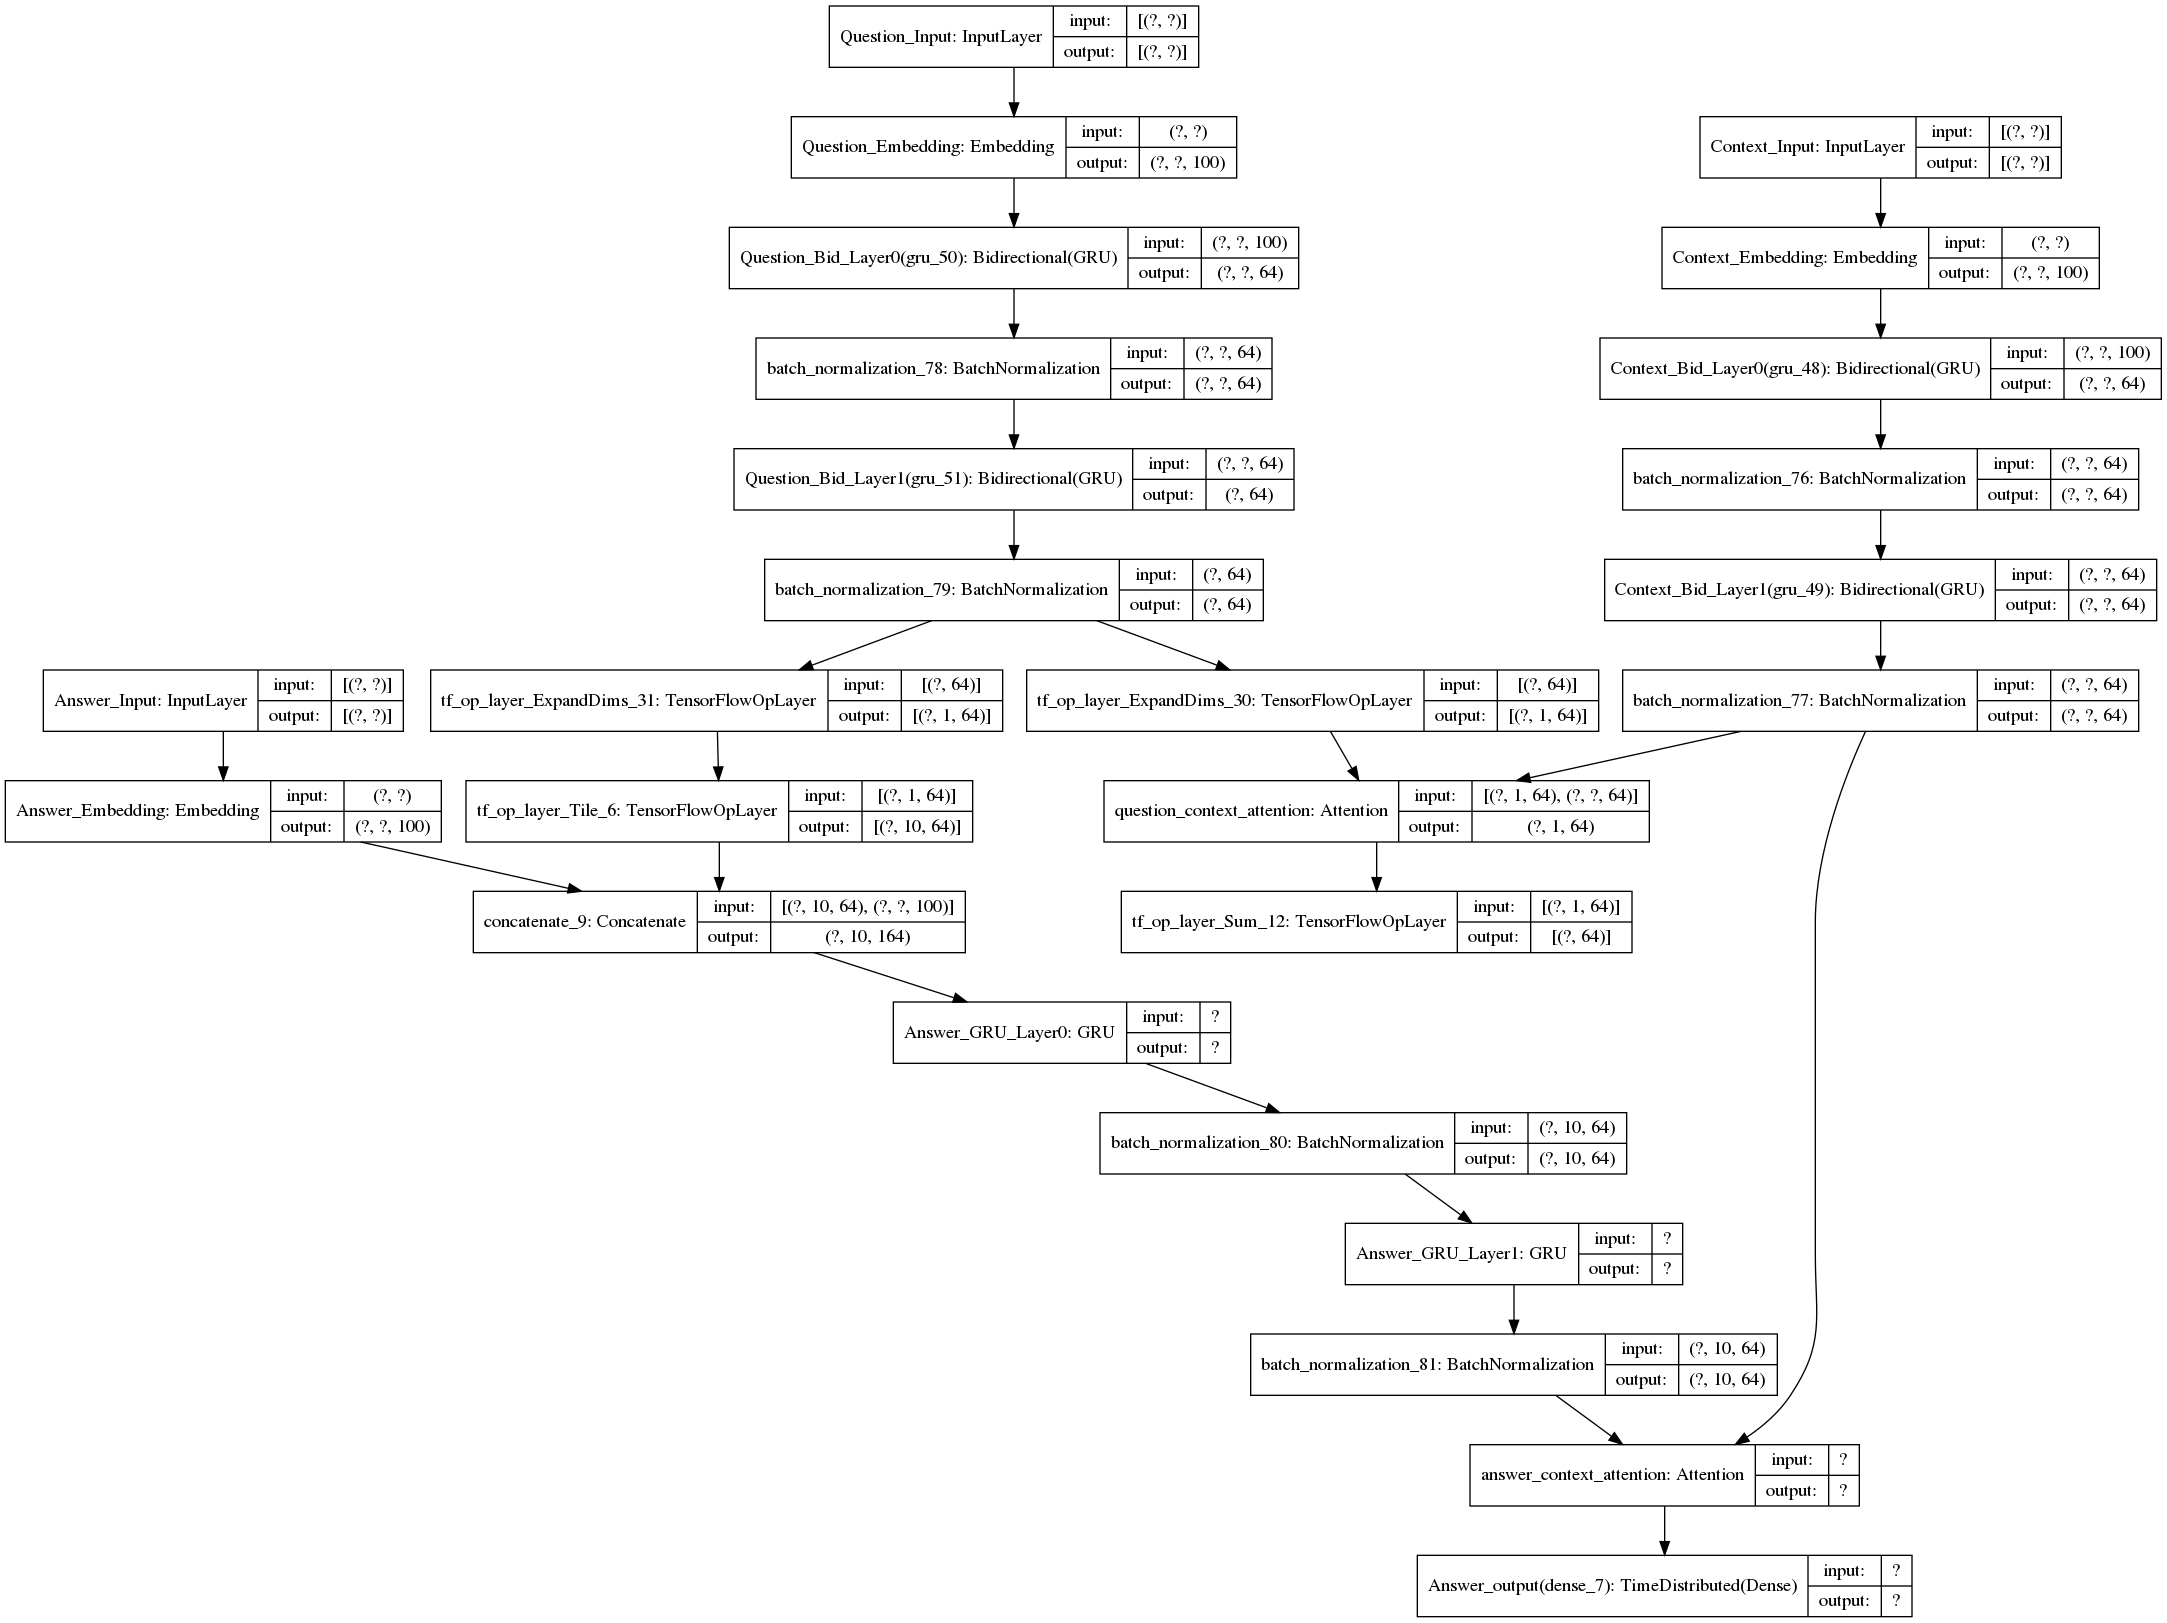

In [62]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(gpu_answer_model,show_shapes=True)

In [ ]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence3(context_input_seq,question_input_seq,gpaqexdE` gq_padded[seq_index].tolist() if i !=0]))
    print('Decoded sentence:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

In [50]:
p = Input(shape=(24,24,))
k =layers.Bidirectional(layers.GRU(24,
                                                                 dropout=0.5,
                                                                 recurrent_dropout= 0.5,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_state=True,
                                                                 return_sequences=True),
                                                      merge_mode='sum')(p)

In [5]:
#Define Experiments using random choice
import random
num_unit_gru_list = [64,80,100]
num_layers_gru_list = [1,2]
num_episodes_list = [1,2,3]
num_dense_layer_feasibility_units_list = [32,48,64]
dropout_rate_list = [0.4,0.5,0.6,0.7]
num_dense_layers_feasibility_list = [1,2,3]
learning_rate_list = [.005,.001]
num_episodic_network_unit_list =[64,128,192]
Experiments = {}
for i in range(6):
    experiment_name = 'Experiment'+str(i)
    experiment_hyperparam_dic = {}
    experiment_num_unit_gru = random.choice(num_unit_gru_list)
    experiment_num_layers_gru = random.choice(num_layers_gru_list)
    experiment_num_episodes = random.choice(num_episodes_list)
    experiment_num_dense_layer_feasibility_units = random.choice(num_dense_layer_feasibility_units_list)
    experiment_dropout_rate = random.choice(dropout_rate_list)
    experiment_num_dense_layers_feasibility = random.choice(num_dense_layers_feasibility_list)
    experiment_num_episodic_network_unit = random.choice(num_episodic_network_unit_list)
    experiment_learning_rate = random.choice(learning_rate_list)
    experiment_hyperparam_dic['num_unit_gru'] = experiment_num_unit_gru
    experiment_hyperparam_dic['num_layers_gru'] = experiment_num_layers_gru
    experiment_hyperparam_dic['num_episodes'] = experiment_num_episodes
    experiment_hyperparam_dic['num_dense_layer_feasibility_units'] = experiment_num_dense_layer_feasibility_units
    experiment_hyperparam_dic['dropout_rate'] = experiment_dropout_rate
    experiment_hyperparam_dic['num_dense_layers_feasibility'] = experiment_num_dense_layers_feasibility
    experiment_hyperparam_dic['num_episodic_network_unit'] = experiment_num_episodic_network_unit
    experiment_hyperparam_dic['learning_rate'] = experiment_learning_rate
    Experiments[experiment_name] = experiment_hyperparam_dic
    
print(Experiments)

{'Experiment0': {'num_unit_gru': 64, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 32, 'dropout_rate': 0.6, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 192, 'learning_rate': 0.001}, 'Experiment1': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 64, 'dropout_rate': 0.7, 'num_dense_layers_feasibility': 3, 'num_episodic_network_unit': 192, 'learning_rate': 0.005}, 'Experiment2': {'num_unit_gru': 100, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 64, 'dropout_rate': 0.5, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 64, 'learning_rate': 0.005}, 'Experiment3': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 32, 'dropout_rate': 0.7, 'num_dense_layers_feasibility': 3, 'num_episodic_network_unit': 192, 'learning_rate': 0.005}, 'Experiment4': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes'

In [6]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 32, 'dropout_rate': 0.6, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 192, 'learning_rate': 0.001}, 'Experiment1': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 64, 'dropout_rate': 0.7, 'num_dense_layers_feasibility': 3, 'num_episodic_network_unit': 192, 'learning_rate': 0.005}, 'Experiment2': {'num_unit_gru': 100, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 64, 'dropout_rate': 0.5, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 64, 'learning_rate': 0.005}, 'Experiment3': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 32, 'dropout_rate': 0.7, 'num_dense_layers_feasibility': 3, 'num_episodic_network_unit': 192, 'learning_rate': 0.005}, 'Experiment4': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 2, 'num_dense_layer_feasibility_units': 48, 'dropout_rate': 0.6, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 128, 'learning_rate': 0.005}, 'Experiment5': {'num_unit_gru': 80, 'num_layers_gru': 2, 'num_episodes': 3, 'num_dense_layer_feasibility_units': 64, 'dropout_rate': 0.5, 'num_dense_layers_feasibility': 1, 'num_episodic_network_unit': 192, 'learning_rate': 0.005}}

Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005},
 'Experiment

In [ ]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    
    
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        decoder_model,\
        feasibility_model = create_models(embedding_matrix = embedding_matrix,
                                              max_context_length = context_maxlen,
                                              max_question_length = question_maxlen,
                                              max_answer_length = answer_maxlen,
                                              num_unit_gru = num_unit_gru,
                                              num_layers_gru = num_layers_gru,
                                              ndim =ndim,
                                              num_episodes = num_episodes,
                                              num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                              dropout_rate = dropout_rate,
                                              num_dense_layers_feasibility = num_dense_layers_feasibility,
                                              num_episodic_network_unit = num_episodic_network_unit)

        adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        answer_model.compile(optimizer=adam_optim,
                                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                                )

        answer_model.summary()
        feasibility_model.compile(optimizer=adam_optim,
                                   loss=tf.keras.losses.BinaryCrossentropy(),
                                   metrics=[tf.keras.metrics.BinaryAccuracy()]
                                   )
        feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            decoder_model,\
            feasibility_model = create_models(embedding_matrix = embedding_matrix,
                                              max_context_length = context_maxlen,
                                              max_question_length = question_maxlen,
                                              max_answer_length = answer_maxlen,
                                              num_unit_gru = num_unit_gru,
                                              num_layers_gru = num_layers_gru,
                                              ndim =ndim,
                                              num_episodes = num_episodes,
                                              num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                              dropout_rate = dropout_rate,
                                              num_dense_layers_feasibility = num_dense_layers_feasibility,
                                              num_episodic_network_unit = num_episodic_network_unit)

            adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            answer_model.compile(optimizer=adam_optim,
                                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                                )

            answer_model.summary()
            feasibility_model.compile(optimizer=adam_optim,
                                       loss=tf.keras.losses.BinaryCrossentropy(),
                                       metrics=[tf.keras.metrics.BinaryAccuracy()]
                                       )
            feasibility_model.summary()
        
        
        
        history_answer_model = answer_model.fit({'Context_Input':train_context_padded_seq[:num_training_samples],
                                                         'Question_Input':train_question_seq_padded[:num_training_samples],
                                                         'Answer_Input':train_answer_input_seq_padded[:num_training_samples] },
                                                        {'Answer_output':train_answer_target_seq_padded[:num_training_samples] },
                                                        epochs=num_epochs,
                                                        batch_size=batch_size,
                                                        validation_data=([val_context_padded_seq[:num_validation_samples],
                                                                          val_question_seq_padded[:num_validation_samples],
                                                                          train_answer_input_seq_padded[:num_validation_samples]],
                                                                         val_answer_target_seq_padded[:num_validation_samples]))
        _,encoder_prediction,_ = encoder_model.predict([train_context_padded_seq[:num_training_samples],
                                                    train_question_seq_padded[:num_training_samples]])
        _,encoder_validation_prediction,_ = encoder_model.predict([val_context_padded_seq[:num_validation_samples],
                                                               val_question_seq_padded[:num_validation_samples]])
        gpu_history_feasibility_model = feasibility_model.fit(encoder_prediction,
                                                                  train_answer_impossible[:num_training_samples],
                                                                  epochs=num_epochs,
                                                                  batch_size=batch_size,
                                                                  validation_data = 
                                                                                 (encoder_validation_prediction,
                                                                                  val_answer_impossible[:num_validation_samples])
                                                                  )


        answer_model.save(ExperimentNo+'original_model_answer_model.h5')
        encoder_model.save(ExperimentNo+'original_model_encoder_model.h5')
        decoder_model.save(ExperimentNo+'original_model_decoder_model.h5')
        feasibility_model.save(ExperimentNo+'original_model_feasibility_model.h5')
        with open(ExperimentNo+'original_model_'+'history_answer_model', 'wb') as file_history:
                pickle.dump(gpu_history_answer_model.history, file_history)
        with open(ExperimentNo+'original_model_'+'history_feasibility_model', 'wb') as file_history:
                pickle.dump(gpu_history_feasibility_model.history, file_history)
    

In [ ]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    
    inference_answer_model,\
    inference_encoder_model,\
    inference_decoder_model,\
    inference_feasibility_model = create_models(embedding_matrix = embedding_matrix,
                                              max_context_length = context_maxlen,
                                              max_question_length = question_maxlen,
                                              max_answer_length = answer_maxlen,
                                              num_unit_gru = num_unit_gru,
                                              num_layers_gru = num_layers_gru,
                                              ndim =ndim,
                                              num_episodes = num_episodes,
                                              num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                              dropout_rate = dropout_rate,
                                              num_dense_layers_feasibility = num_dense_layers_feasibility,
                                              num_episodic_network_unit = num_episodic_network_unit)


    inference_answer_model.load_weights(ExperimentNo+'original_model_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'original_model_encoder_model.h5')
    inference_decoder_model.load_weights(ExperimentNo+'original_model_decoder_model.h5')
    inference_feasibility_model.load_weights(ExperimentNo+'original_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_decoder_model,inference_feasibility_model)

In [ ]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_decoder_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

In [6]:
import pickle
with open('Experiment0original_model_history_answer_model', 'rb') as file_history:
    new_dict = pickle.load(file_history)
    #print(type(new_dict))
    new_dict
new_dict

{'loss': [3.7944753016345203,
  2.9194746776483953,
  2.0790340420790017,
  1.590407236944884,
  1.485952205141075,
  1.4509005151921883,
  1.4289854364469647,
  1.4004782919073477,
  1.3904453750001267,
  1.3744971922133118,
  1.3635061669629067,
  1.3495788625441492,
  1.3418535549426451,
  1.3342625845689327,
  1.322531937272288,
  1.3146142672048882,
  1.300641571811866,
  1.2923762707505375,
  1.2820082801626995,
  1.2746985239209607,
  1.2658366296673194,
  1.2518018482951447,
  1.2491665349225514,
  1.240484379697591,
  1.2355039091780782,
  1.2232803188962862,
  1.218014606856741,
  1.2048673920799047,
  1.2015438944799826,
  1.1849605978932232,
  1.1839567940915003,
  1.1750995002803393,
  1.1691947520012036,
  1.161529769655317,
  1.1581727805896662,
  1.1446026907069609,
  1.134896906267386,
  1.1327806821209379,
  1.1208479771157727,
  1.1144782649935223,
  1.1075839197728783,
  1.0964388356078416,
  1.0902888941927813,
  1.088150656723883,
  1.0777087146416306,
  1.0747821

In [8]:
import tensorflow as tf
m = tf.keras.metrics.SparseCategoricalAccuracy() 
_ = m.update_state([[2,1], [1,2]], [ [[0.1, 0.9,0.8],[0.1,0.9,0.8]], [[0.05, 0.95, 0],[0.1,0.9,0.8]] ]) 
m.result().numpy() 


0.5

In [2]:
import random
l1_weight_list = [.01,.001,.0001]
l2_weight_list = [.01,.001,.0001]
for i in range(6):
    print('Experiment: '+str(i))
    print("'l1_regularizer_weight:'"+str(random.choice(l1_weight_list)))
    print("'l2_regularizer_weight:'"+str(random.choice(l2_weight_list)))

Experiment: 0
'l1_regularizer_weight:'0.01
'l2_regularizer_weight:'0.01
Experiment: 1
'l1_regularizer_weight:'0.0001
'l2_regularizer_weight:'0.01
Experiment: 2
'l1_regularizer_weight:'0.01
'l2_regularizer_weight:'0.01
Experiment: 3
'l1_regularizer_weight:'0.01
'l2_regularizer_weight:'0.0001
Experiment: 4
'l1_regularizer_weight:'0.001
'l2_regularizer_weight:'0.001
Experiment: 5
'l1_regularizer_weight:'0.001
'l2_regularizer_weight:'0.0001


In [4]:
dd = {'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight':0.01,
  'l2_regularizer_weight':0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight':0.0001,
  'l2_regularizer_weight':0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight':0.01,
  'l2_regularizer_weight':0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight':0.01,
  'l2_regularizer_weight':0.0001},
 'Experiment4': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 48,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 128,
  'learning_rate': 0.005,
  'l1_regularizer_weight':0.001,
  'l2_regularizer_weight':0.001},
 'Experiment5': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight':0.001,
  'l2_regularizer_weight':0.0001}
}